In [ ]:
# !pip install tensorflow-addons==0.19.0
# !pip install tensorflow==2.11.1

In [28]:
import torch
import json
import gensim.downloader as api
import numpy as np
import pickle
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed
from keras.optimizers import Adam
import keras.backend as K
import keras.layers as L
import tensorflow_addons as tfa
from tensorflow_addons.text import crf_log_likelihood, crf_decode
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [29]:
with open('/content/drive/MyDrive/A2/Json Task1/train_processed.json', 'r') as f:
    task1_train_data = json.load(f)

with open('/content/drive/MyDrive/A2/Json Task1/val_processed.json', 'r') as f:
    task1_val_data = json.load(f)

with open('/content/drive/MyDrive/A2/Json Task1/test_processed.json', 'r') as f:
    task1_test_data = json.load(f)

with open('/content/drive/MyDrive/A2/Json Task2/train_processed.json', 'r') as f:
    task2_train_data = json.load(f)

with open('/content/drive/MyDrive/A2/Json Task2/val_processed.json', 'r') as f:
    task2_val_data = json.load(f)

with open('/content/drive/MyDrive/A2/Json Task2/test_processed.json', 'r') as f:
    task2_test_data = json.load(f)

with open('/content/drive/MyDrive/A2/glove_embedding.pkl', 'rb') as pickle_file:
    glove_embeddings = pickle.load(pickle_file)

with open('/content/drive/MyDrive/A2/fast_text_embedding.pkl', 'rb') as pickle_file:
    fast_text_embedding = pickle.load(pickle_file)

with open('/content/drive/MyDrive/A2/word2vec_embeddings.pkl', 'rb') as pickle_file:
    word2vec_embeddings = pickle.load(pickle_file)

bio_mapping_task1 = {'B_ORG': 0, 'I_ORG': 1, 'B_RESPONDENT': 2, 'I_RESPONDENT': 3, 'B_JUDGE': 4, 'I_JUDGE': 5,
               'B_STATUTE': 6, 'I_STATUTE': 7, 'B_OTHER_PERSON': 8, 'I_OTHER_PERSON': 9, 'B_COURT': 10, 'I_COURT': 11,
               'B_GPE': 12, 'I_GPE': 13, 'B_PETITIONER': 14, 'I_PETITIONER': 15, 'B_WITNESS': 16, 'I_WITNESS': 17,
               'B_CASE_NUMBER': 18, 'I_CASE_NUMBER': 19, 'B_PRECEDENT': 20, 'I_PRECEDENT': 21, 'B_DATE': 22, 'I_DATE': 23,
               'B_PROVISION': 24, 'I_PROVISION': 25, 'O': 26}

bio_mapping_task2 = {'O' : 0, 'I' : 1, 'B' : 2}

In [ ]:
# word2vec_model = api.load('word2vec-google-news-300')
# word2vec = torch.FloatTensor(word2vec_model.vectors)
# word2vec_u_ = np.concatenate((word2vec, np.zeros((1, 300), dtype = 'float32')), axis = 0)

# word_to_index_w2v = {word: index for index, word in enumerate(word2vec_model.index_to_key)}
# word_to_index_w2v['<unk>'] = len(word_to_index_w2v)
# vocab_size_w2v = len(word_to_index_w2v)

# word2vec_embeddings = {word: word2vec_u_[index] for word, index in word_to_index_w2v.items()}

In [30]:
word_to_index_w2v = {}
ind = 0
word2vec_embeddings['<unk>'] = np.zeros((1, 300), dtype = 'float32')

for word in word2vec_embeddings.keys():
  word_to_index_w2v[word] = ind
  ind = ind + 1

vocab_size_w2v = len(word_to_index_w2v)

word_to_index_glove = {}
ind = 0
glove_embeddings['<unk>'] = np.zeros((1, 300), dtype = 'float32')

for word in glove_embeddings.keys():
  word_to_index_glove[word] = ind
  ind = ind + 1

vocab_size_glove = len(word_to_index_glove)
word_to_index_fasttext = {}
ind = 0
fast_text_embedding['<unk>'] = np.zeros((1, 300), dtype = 'float32')

for word in fast_text_embedding.keys():
  word_to_index_fasttext[word] = ind
  ind = ind + 1

vocab_size_fasttext = len(word_to_index_fasttext)
max_seq_len = 84

In [33]:
def process_data(dataset,task,embedding_type):
    sentences = []
    labels = []

    if task == 1:
        bio_mapping = bio_mapping_task1
    else:
        bio_mapping = bio_mapping_task2

    if embedding_type == "word2vec":
        word_to_index = word_to_index_w2v

    elif embedding_type == "glove":
        word_to_index = word_to_index_glove

    else:
        word_to_index = word_to_index_fasttext

    for index in dataset.keys():

        dic = dataset[index]
        tags = [bio_mapping[label] for label in dic['labels']]
        sentence = dic['text'].split(' ')
        sequence = []
        for word in sentence:
            if word in word_to_index:
                sequence.append(word_to_index[word])
            else:
                sequence.append(word_to_index['<unk>'])


        if(len(sequence) >= max_seq_len):
          continue

        if(len(sequence) < max_seq_len):
            for i in range(len(sequence), max_seq_len):
                sequence.append(word_to_index['<unk>'])
                tags.append(bio_mapping['O'])

        sentences.append(sequence)
        labels.append(tags)

    return sentences, labels

In [41]:
type_embedding = "fast_text"
bio_mapping = bio_mapping_task2
word_index = word_to_index_fasttext
vocab = vocab_size_fasttext

X_train, y_train = process_data(task2_train_data, 2, type_embedding)
X_test, y_test = process_data(task2_test_data, 2, type_embedding)
X_val, y_val = process_data(task2_val_data, 2, type_embedding)

tag_size = len(bio_mapping)

y_train = [to_categorical(i, num_classes = tag_size) for i in y_train]
y_val = [to_categorical(i, num_classes = tag_size) for i in y_val]
y_test = [to_categorical(i, num_classes = tag_size) for i in y_test]

y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [36]:
class CRF(L.Layer):
    def __init__(self, output_dim, **kwargs):
        super(CRF, self).__init__(**kwargs)
        self.output_dim = int(output_dim)
        self.transitions = None

    def build(self, input_shape):
        self.transitions = self.add_weight(name = 'transitions', shape=[self.output_dim, self.output_dim],
                                           initializer = 'glorot_uniform', trainable = True)

    def call(self, inputs, sequence_lengths = None, training = None, **kwargs):
        sequences = tf.convert_to_tensor(inputs, dtype = self.dtype)
        if sequence_lengths is not None:
            self.sequence_lengths = K.flatten(sequence_lengths)
        else:
            self.sequence_lengths = tf.ones(tf.shape(inputs)[0], dtype = tf.int32) * tf.shape(inputs)[1]

        viterbi_sequence, _ = crf_decode(sequences, self.transitions, self.sequence_lengths)
        output = K.one_hot(viterbi_sequence, self.output_dim)
        return K.in_train_phase(sequences, output)

    @property
    def loss(self):
        def crf_loss(y_true, y_pred):
            log_likelihood, self.transitions = crf_log_likelihood(y_pred,
                                                                  tf.cast(K.argmax(y_true), dtype=tf.int32),
                                                                  self.sequence_lengths,
                                                                  transition_params=self.transitions)
            return tf.reduce_mean(-log_likelihood)
        return crf_loss

    @property
    def accuracy(self):
        def viterbi_accuracy(y_true, y_pred):
            mask = K.cast(K.all(K.greater(y_pred, -1e10), axis=2), K.floatx())
            shape = tf.shape(y_pred)
            sequence_lengths = tf.ones(shape[0], dtype=tf.int32) * shape[1]
            y_pred, _ = crf_decode(y_pred, self.transitions, sequence_lengths)
            y_true = K.argmax(y_true, 2)
            y_pred = K.cast(y_pred, 'int32')
            y_true = K.cast(y_true, 'int32')
            corrects = K.cast(K.equal(y_true, y_pred), K.floatx())
            return K.sum(corrects * mask) / K.sum(mask)
        return viterbi_accuracy

In [37]:
def build_2(vocab_size, word_index, emb_type):

    if emb_type == "word2vec":
        embeddings_index = word2vec_embeddings

    elif emb_type == "glove":
        embeddings_index = glove_embeddings
    else:
        embeddings_index = fast_text_embedding

    embeddings_index = {}
    embeddings_matrix = np.zeros((vocab_size,300))

    for word, i in word_index.items():
        if i > vocab_size:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embeddings_matrix[i] = embedding_vector

    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, output_dim = 300, input_length = 84, weights = [embeddings_matrix], mask_zero = True))
    model.add(Bidirectional(LSTM(units = 100, return_sequences = True, recurrent_dropout = 0.05)))
    model.add(Bidirectional(LSTM(units = 32, return_sequences = True, recurrent_dropout = 0.15)))
    model.add(TimeDistributed(Dense(3)))
    crf = CRF(3)
    model.add(crf)
    return model

In [38]:
def calculate_f1_score(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_argmax = np.argmax(y_pred, axis=-1)
    y_true_argmax = np.argmax(y_test, axis=-1)
    f1 = f1_score(y_true_argmax.flatten(), y_pred_argmax.flatten(), average = 'macro')
    return f1

In [39]:
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val, X_test, y_test):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test
        self.train_losses = []
        self.val_losses = []
        self.train_f1_scores = []
        self.val_f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        train_loss = logs['loss']
        self.train_losses.append(train_loss)

        train_f1_score = calculate_f1_score(self.model, X_train, y_train)
        self.train_f1_scores.append(train_f1_score)

        val_loss = self.model.evaluate(self.X_val, self.y_val, verbose=0)[0]
        self.val_losses.append(val_loss)

        val_f1_score = calculate_f1_score(self.model, self.X_val, self.y_val)
        self.val_f1_scores.append(val_f1_score)

        print(f'Epoch {epoch + 1} - Train Loss: {train_loss} - Val Loss: {val_loss} - Train F1 Score: {train_f1_score} - Val F1 Score: {val_f1_score}')

    def plot_results(self):
        epochs = range(1, len(self.train_losses) + 1)
        plt.figure(figsize = (12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label = 'Training Loss')
        plt.plot(epochs, self.val_losses, label = 'Validation Loss')
        plt.title('Training and Validation Losses')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_f1_scores, label = 'Training Macro F1-Score')
        plt.plot(epochs, self.val_f1_scores, label = 'Validation Macro F1-Score')
        plt.title('Training and Validation Macro F1-Scores')
        plt.xlabel('Epochs')
        plt.ylabel('Macro F1-Score')
        plt.legend()

        plt.tight_layout()
        plt.show()

7/7 [==============================] - 1s 120ms/step
Epoch 1 - Train Loss: 18.900405883789062 - Val Loss: 43.50862121582031 - Train F1 Score: 0.32919834423063704 - Val F1 Score: 0.329410039232941
7/7 [==============================] - 1s 122ms/step
Epoch 2 - Train Loss: 7.6395745277404785 - Val Loss: 43.462100982666016 - Train F1 Score: 0.32919834423063704 - Val F1 Score: 0.329410039232941
7/7 [==============================] - 1s 121ms/step
Epoch 3 - Train Loss: 5.973559856414795 - Val Loss: 43.56571960449219 - Train F1 Score: 0.39149923696655603 - Val F1 Score: 0.36310320163075577
7/7 [==============================] - 1s 205ms/step
Epoch 4 - Train Loss: 3.0480329990386963 - Val Loss: 43.258026123046875 - Train F1 Score: 0.8733511495404226 - Val F1 Score: 0.7097829233111753
7/7 [==============================] - 1s 118ms/step
Epoch 5 - Train Loss: 1.9953210353851318 - Val Loss: 43.297393798828125 - Train F1 Score: 0.9118273638008345 - Val F1 Score: 0.7491404956033171
7/7 [===========

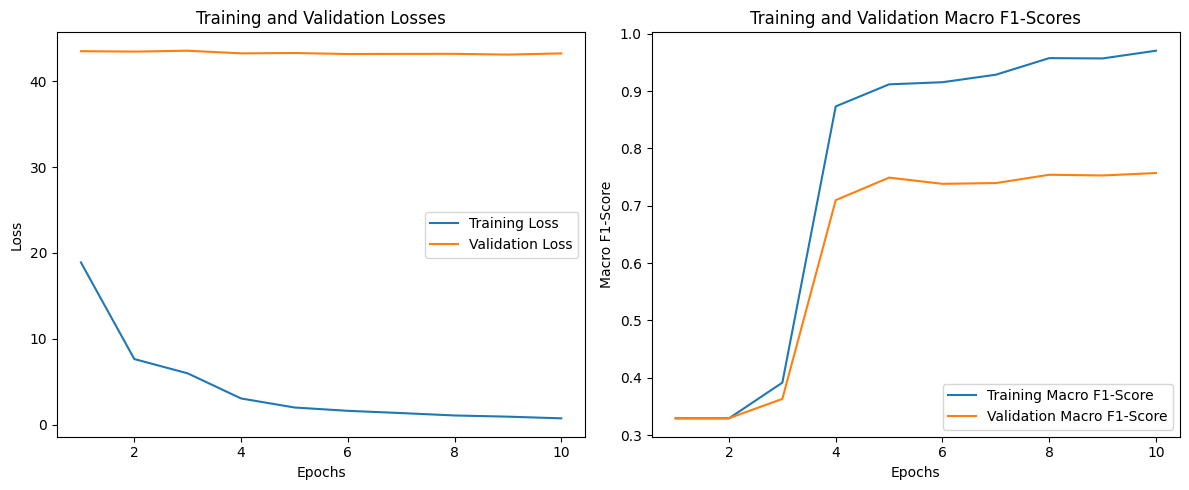

In [40]:
# model = create_model(vocab_size = vocab, max_length = max_seq_len, embedding_dim = 300, word_index = word_index, tag_index = bio_mapping, emb_type = type_embedding)

# model.compile(optimizer = keras.optimizers.legacy.Adam(learning_rate = 1e-3), loss = model.layers[-1].loss, metrics = [model.layers[-1].accuracy])

# metrics_callback = MetricsCallback(X_val, y_val, X_test, y_test)

# history = model.fit(X_train, y_train, batch_size = 16, epochs = 10, validation_data = (X_val, y_val), verbose = 0, callbacks = [metrics_callback])

# test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose = 0)
# test_f1_score = calculate_f1_score(model, X_test, y_test)
# print(f'Test Loss: {test_loss} - Test Accuracy: {test_accuracy} - Test F1 Score: {test_f1_score}')

# metrics_callback.plot_results()

# model.save('/content/drive/MyDrive/A2/trained_models/t2_bilstm_crf_glove.h5')

7/7 [==============================] - 1s 217ms/step
Epoch 1 - Train Loss: 16.125099182128906 - Val Loss: 39.233619689941406 - Train F1 Score: 0.32919834423063704 - Val F1 Score: 0.329410039232941
7/7 [==============================] - 1s 119ms/step
Epoch 2 - Train Loss: 7.619138240814209 - Val Loss: 39.037620544433594 - Train F1 Score: 0.32919834423063704 - Val F1 Score: 0.329410039232941
7/7 [==============================] - 1s 120ms/step
Epoch 3 - Train Loss: 4.927880764007568 - Val Loss: 38.22019958496094 - Train F1 Score: 0.6209404507626081 - Val F1 Score: 0.5506391868068453
7/7 [==============================] - 1s 119ms/step
Epoch 4 - Train Loss: 2.618809223175049 - Val Loss: 37.84286880493164 - Train F1 Score: 0.8766011480875185 - Val F1 Score: 0.7148362452171501
7/7 [==============================] - 1s 120ms/step
Epoch 5 - Train Loss: 1.8662292957305908 - Val Loss: 37.65489959716797 - Train F1 Score: 0.9202335453053743 - Val F1 Score: 0.7491776330748027
7/7 [================

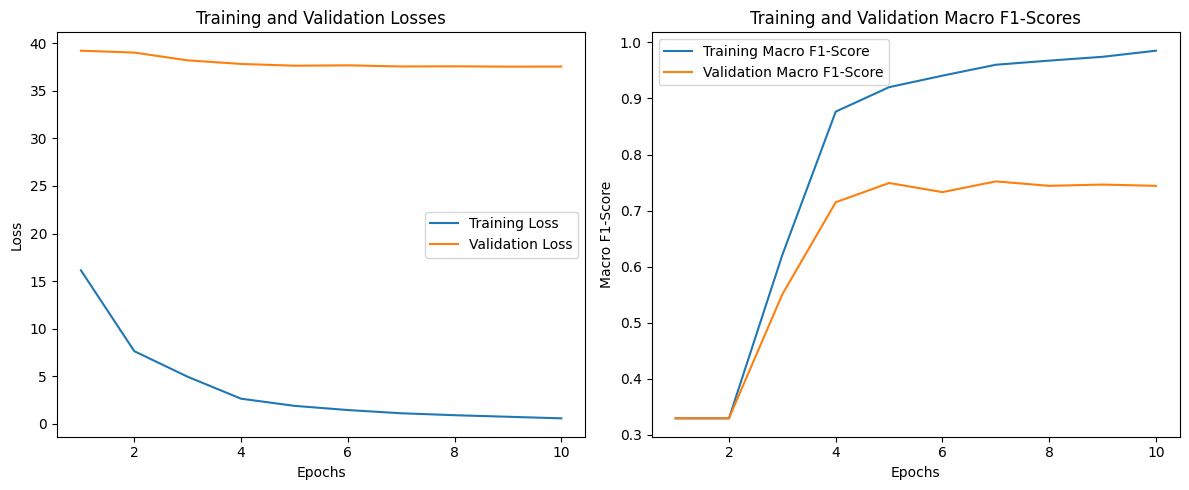

In [42]:
model = build_2(vocab_size = vocab,  word_index = word_index,  emb_type = type_embedding)

model.compile(optimizer = keras.optimizers.legacy.Adam(learning_rate = 1e-3), loss = model.layers[-1].loss, metrics = [model.layers[-1].accuracy])

metrics_callback = MetricsCallback(X_val, y_val, X_test, y_test)

history = model.fit(X_train, y_train, batch_size = 16, epochs = 10, validation_data = (X_val, y_val), verbose = 0, callbacks = [metrics_callback])

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose = 0)
test_f1_score = calculate_f1_score(model, X_test, y_test)
print(f'Test Loss: {test_loss} - Test Accuracy: {test_accuracy} - Test F1 Score: {test_f1_score}')

metrics_callback.plot_results()

model.save('/content/drive/MyDrive/A2/trained_models/t2_bilstm_crf_fasttext.h5')